In [35]:
import pandas as pd
import numpy as np
import psycopg2


from sqlalchemy import create_engine
# Importing the libraries
from sklearn.model_selection import train_test_split # for data validation

# Models
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoLars
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Metrics and Grid Search
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score, confusion_matrix, accuracy_score, classification_report, r2_score# Setting the default style of the plots

### Database Connection

In [36]:
# Connection parameters, yours will be different
param_dic = {
    "host"      : "localhost",
    "port": 5432,
    "database"  : "World_Happiness",
    "user"      : "postgres",
    "password"  : "020849"
}
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn


In [37]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

### Retrieving Data join Happiness table and World Mortality by Covid

In [38]:
# Connect to the database
conn = connect(param_dic)
column_names = ['Country name','year','Happiness_ranking', 'Deaths_byCovid']
# Execute the  query
happines_covid_df00 = postgresql_to_dataframe(conn, "select  wmc.country_name, w.year, w.happiness_ranking, wmc.number_deaths \
                                    from world_happiness w INNER JOIN world_mortality_by_covid wmc ON wmc.country_code=w.country_code AND w.year=wmc.year AND w.year=2020 \
                                    order by wmc.number_deaths DESC LIMIT 10 ", column_names)

happines_covid_df21 = postgresql_to_dataframe(conn, "select  wmc.country_name, w.year, w.happiness_ranking, wmc.number_deaths \
                                    from world_happiness w INNER JOIN world_mortality_by_covid wmc ON wmc.country_code=w.country_code AND w.year=wmc.year AND w.year=2021 \
                                    order by wmc.number_deaths DESC LIMIT 10 ", column_names)

happines_covid_df00.to_csv('happines_covid2020.csv', index=None)
happines_covid_df21.to_csv('happines_covid2021.csv', index=None)
happines_covid_df21.head()

Connecting to the PostgreSQL database...
Connection successful


,Country name,year,Happiness_ranking,Deaths_byCovid
0,United States of America,2021,6.959087849,467012
1,Brazil,2021,6.009953499,426136
2,India,2021,3.558253765,332342
3,Russian Federation,2021,5.448261261,251841
4,Mexico,2021,5.99075079,156199


### Retrieving Data join Happiness table and World Mortality 

In [39]:
conn = connect(param_dic)
column_names = ['Country name','year','Happiness_ranking', 'All_deaths']
# Execute the  query
happines_mortality_df00 = postgresql_to_dataframe(conn,'select  wmc.country_name, w.year, w.happiness_ranking, wmc.number_deaths \
                                                        from world_happiness w INNER JOIN world_mortality_by_covid wmc ON wmc.country_code=w.country_code AND w.year=wmc.year AND w.year=2020 \
                                                    order by wmc.number_deaths DESC LIMIT 10', column_names) 

happines_mortality_df21 = postgresql_to_dataframe(conn,'select  wmc.country_name, w.year, w.happiness_ranking, wmc.number_deaths \
                                                        from world_happiness w INNER JOIN world_mortality_by_covid wmc ON wmc.country_code=w.country_code AND w.year=wmc.year AND w.year=2021 \
                                                    order by wmc.number_deaths DESC LIMIT 10', column_names) 

happines_mortality_df00.to_csv('happines_mortality2020.csv', index=None)
happines_mortality_df21.to_csv('happines_mortality2021.csv', index=None)
happines_mortality_df21.head()

Connecting to the PostgreSQL database...
Connection successful


,Country name,year,Happiness_ranking,All_deaths
0,United States of America,2021,6.959087849,467012
1,Brazil,2021,6.009953499,426136
2,India,2021,3.558253765,332342
3,Russian Federation,2021,5.448261261,251841
4,Mexico,2021,5.99075079,156199


### Retrieving Data join Happiness table and World Population

In [40]:
conn = connect(param_dic)
column_names = ['year', 'Country name','Happiness_ranking', 'Population']
# Execute the  query
happines_population = postgresql_to_dataframe(conn,'select w.year, po.country_name , w.happiness_ranking, po.population \
                                                        from world_happiness w INNER JOIN population po ON \
                                                        po.country_code=w.country_code AND w.year=po.year \
                                                        order by population DESC', column_names) 
happines_population['Happiness_ranking'] = happines_population['Happiness_ranking'].astype(float)

happines_population

Connecting to the PostgreSQL database...
Connection successful


,year,Country name,Happiness_ranking,Population
0,2021,China,5.862864,1412360000
1,2020,China,5.771065,1411100000
2,2019,China,5.144120,1407745000
3,2018,China,5.131434,1402760000
4,2017,China,5.099061,1396215000
...,...,...,...,...
2033,2015,Iceland,7.498071,330815
2034,2013,Iceland,7.501394,323764
2035,2012,Iceland,7.590660,320716
2036,2008,Iceland,6.888284,317414


In [41]:
happines_population= happines_population.reindex()
#happines_population.shape
happines_population = happines_population.groupby(by= 'Country name')['Happiness_ranking','Population'].mean().reset_index()
happiness_mostpopulated= happines_population.head(10)
happiness_lesspopulated=happines_population.tail(10)
happiness_mostpopulated.to_csv('happiness_mostpopulated.csv', index=None)
happiness_lesspopulated.to_csv('happiness_lesspopulated.csv', index=None)

/var/folders/zq/rwx6mtq50yd_vfcnh_qt_z580000gn/T/ipykernel_47300/1505454067.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  happines_population = happines_population.groupby(by= 'Country name')['Happiness_ranking','Population'].mean().reset_index()


### Retrieving from World Happiness table (Main Dataset)

In [42]:
conn = connect(param_dic)
column_names = ['Country Code','Country name','year','Happiness_ranking', 'Log GDP per capita','Social support', 'Healthy life expectancy at birth','Freedom to make life choices', 'Generosity',\
                'Perceptions of corruption','Positive affect', 'Negative affect', 'Confidence in national government']
# Execute the "SELECT *" query
world_happiness = postgresql_to_dataframe(conn, "select * from world_happiness", column_names)

world_happiness.to_csv('world_happiness.csv', index=None)
world_happiness.head()

Connecting to the PostgreSQL database...
Connection successful


,Country Code,Country name,year,Happiness_ranking,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government
0,AFG,Afghanistan,2008,3.723589897,7.302573681,0.450662315,50.5,0.718114316,0.173169285,0.88168633,0.414297044,0.25819549,0.61207211
1,AFG,Afghanistan,2009,4.401778221,7.472446442,0.55230844,50.79999924,0.678896368,0.195469126,0.850035429,0.481421441,0.23709242,0.611545205
2,AFG,Afghanistan,2010,4.75838089,7.579182625,0.539075196,51.09999847,0.60012722,0.125859469,0.706766069,0.516906679,0.275323808,0.299357414
3,AFG,Afghanistan,2011,3.83171916,7.552006245,0.521103561,51.40000153,0.495901406,0.167722777,0.731108546,0.479834676,0.267174691,0.307385713
4,AFG,Afghanistan,2012,3.782937527,7.637953281,0.520636737,51.70000076,0.530935049,0.241247073,0.775619805,0.613512814,0.267919123,0.435440153


In [43]:
world_happiness= world_happiness.astype({'Happiness_ranking':'float', 'Log GDP per capita':'float','Social support':'float', 'Healthy life expectancy at birth':'float', 'Freedom to make life choices':'float','Generosity':'float',\
                                         'Perceptions of corruption':'float', 'Positive affect':'float' , 'Negative affect' :'float' , 'Confidence in national government':'float'})
world_happiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2074 entries, 0 to 2073
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country Code                       2074 non-null   object 
 1   Country name                       2074 non-null   object 
 2   year                               2074 non-null   int64  
 3   Happiness_ranking                  2074 non-null   float64
 4   Log GDP per capita                 2074 non-null   float64
 5   Social support                     2074 non-null   float64
 6   Healthy life expectancy at birth   2074 non-null   float64
 7   Freedom to make life choices       2074 non-null   float64
 8   Generosity                         2074 non-null   float64
 9   Perceptions of corruption          2074 non-null   float64
 10  Positive affect                    2074 non-null   float64
 11  Negative affect                    2074 non-null   float

In [44]:
world_happiness= world_happiness.reindex()

### World Happiness Model

In [45]:
world_happiness.shape

(2074, 13)

In [46]:
#Grouping the dataset by Country name and calculate the Mean
data_model = world_happiness.groupby(by= 'Country name')['Happiness_ranking', 'Log GDP per capita','Social support', 'Healthy life expectancy at birth','Freedom to make life choices',\
                        'Generosity','Perceptions of corruption', 'Positive affect', 'Negative affect','Confidence in national government'].mean().reset_index()
data_model

/var/folders/zq/rwx6mtq50yd_vfcnh_qt_z580000gn/T/ipykernel_47300/544797881.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_model = world_happiness.groupby(by= 'Country name')['Happiness_ranking', 'Log GDP per capita','Social support', 'Healthy life expectancy at birth','Freedom to make life choices',\


,Country name,Happiness_ranking,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government
0,Afghanistan,3.505506,6.999711,0.504086,52.353846,0.508496,0.069534,0.851207,0.450821,0.348225,0.382015
1,Albania,5.036288,9.378583,0.715285,68.457500,0.674589,-0.073345,0.871272,0.558089,0.296007,0.320455
2,Algeria,5.377251,9.334042,0.733343,66.080000,0.424643,-0.110925,0.558139,0.482105,0.240385,0.000000
3,Angola,4.420299,8.989725,0.737973,52.150001,0.455957,-0.088896,0.867018,0.625734,0.351173,0.397389
4,Argentina,6.285048,10.031485,0.903041,66.628125,0.771455,-0.152174,0.840388,0.739983,0.287840,0.381224
...,...,...,...,...,...,...,...,...,...,...,...
158,Venezuela,5.962723,7.515371,0.903985,64.987813,0.661967,-0.078452,0.797000,0.776460,0.268086,0.371462
159,Vietnam,5.330300,8.700916,0.771421,64.806250,0.721846,0.014898,0.589778,0.530464,0.203218,0.424182
160,Yemen,3.912124,7.925330,0.739803,58.309167,0.622404,-0.118913,0.618624,0.458260,0.293548,0.361886
161,Zambia,4.453841,8.066699,0.729828,51.535000,0.761771,0.022134,0.828492,0.678728,0.297978,0.572063


In [47]:
#Creating the table model

# Creating the independent and depend variables
y = data_model['Happiness_ranking']
X = data_model[['Log GDP per capita','Social support', 'Healthy life expectancy at birth','Freedom to make life choices',\
               'Generosity' ,'Perceptions of corruption','Positive affect', 'Negative affect','Confidence in national government']]

# Splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=1)

In [48]:
y_test.count()

115

In [49]:
# Creating a predefined function to test the models
def modelfit(model):
   model.fit(X_train, y_train)
   preds = model.predict(X_test)
   mae = metrics.mean_absolute_error(y_test, preds)
   return (round(mae,4))

In [50]:
#Linear Regression
lm = LinearRegression(n_jobs = 10000)
model1=('Linear Regression', modelfit(lm))

# Random Forest Regressor
rf = RandomForestRegressor()
model2=('Random Forest Regressor', modelfit(rf))

# XGBoost
xg = XGBRegressor(learning_rate=0.1, n_estimators=5000)
model3=('XGBoost',modelfit(xg))

# Decision Tree
dt = DecisionTreeRegressor()
model4= ('Decision Tree', modelfit(dt))

# Bayesian Linear Model
br = BayesianRidge(n_iter=1000, tol = 0.5)
model5=('Bayesian Linear Model', modelfit(br))

#Create a DataFrame with Models
models = pd.DataFrame(data= [model1, model2, model3, model4, model5], columns=['Model', 'MAE'])
models

,Model,MAE
0,Linear Regression,0.4354
1,Random Forest Regressor,0.3280
2,XGBoost,0.3620
3,Decision Tree,0.4749
4,Bayesian Linear Model,0.4179


### XGBRegressor Model

In [51]:
xg_reg_model = xgb.XGBRegressor(objective ='reg:linear', learning_rate = 0.1, n_estimators=5000)
xg_reg_model.fit(X_train, y_train)
xg_predictions = xg_reg_model.predict(X_test)
xg_predictions

[13:54:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


array([5.809531 , 4.598067 , 4.573328 , 6.66137  , 4.4436207, 5.339028 ,
       5.6887484, 5.15169  , 4.3821282, 4.068949 , 5.3977675, 4.8752093,
       4.10824  , 5.5540915, 4.8893824, 5.6385584, 4.360864 , 7.2315907,
       4.5256715, 5.6530395, 4.9400334, 5.3267527, 7.230801 , 4.264135 ,
       6.451656 , 4.83888  , 4.605018 , 7.084248 , 5.5855846, 4.982052 ,
       4.445378 , 6.726093 , 4.660011 , 4.3983774, 4.7581854, 6.1741524,
       5.0910664, 4.4441657, 5.7617197, 5.5554132, 4.981799 , 4.365449 ,
       4.3350563, 6.6209455, 5.193304 , 4.575743 , 6.530115 , 6.792422 ,
       5.3949156, 5.440089 , 6.638213 , 5.887145 , 6.2753897, 6.2319603,
       4.678972 , 4.5197906, 4.47003  , 6.0445685, 5.5681505, 4.6956487,
       7.4177885, 5.7916555, 6.417821 , 6.227505 , 6.432721 , 4.853442 ,
       7.269083 , 4.751603 , 5.389644 , 4.6883802, 6.13329  , 4.747873 ,
       4.55097  , 6.378684 , 7.0834584, 4.0988846, 5.261743 , 4.674678 ,
       5.0720596, 5.855298 , 4.0743127, 5.7382226, 

In [52]:
r2_score(y_test, xg_predictions)

0.7864640652856381

### RandomForestRegressor Model

In [53]:
# Create a random forest regresor.
rf_model = RandomForestRegressor(n_estimators=128, random_state=78) 
rf_model = rf_model.fit(X_train, y_train)
rf_predictions= rf_model.predict(X_test)
rf_predictions

array([5.37488244, 4.38540537, 4.83754314, 6.37790757, 4.32917301,
       5.32746162, 5.54137731, 5.63897788, 4.8462724 , 4.38049118,
       5.25648517, 4.86604705, 4.21357531, 5.35493702, 4.9502974 ,
       5.58455002, 4.32813119, 7.35951272, 4.55817506, 5.97873236,
       4.77705429, 5.25595275, 7.32083888, 4.41594246, 6.41277757,
       4.67467086, 4.64641273, 7.22288798, 6.179403  , 4.95687167,
       4.38379219, 6.85979037, 4.81263061, 4.27234766, 5.09661456,
       5.76198138, 5.18112766, 4.63139901, 6.10368427, 5.70707813,
       5.0625777 , 4.38265867, 4.38906198, 6.42757919, 5.95606142,
       4.73610103, 6.37531275, 6.85586707, 5.3275135 , 5.48714409,
       6.14527228, 5.43959347, 6.16148731, 6.17646665, 5.17446222,
       4.62529562, 4.4190945 , 5.3750108 , 5.67363493, 5.04326052,
       7.22481143, 5.6797857 , 6.18638674, 6.39353935, 6.25277906,
       5.27964522, 6.71692924, 4.59598474, 5.31477189, 4.59767152,
       5.94558957, 4.94872208, 4.78499782, 6.63180779, 7.21107

In [54]:
r2_score(y_test, rf_predictions)

0.821484569798011

### Correlation Matrix

/var/folders/zq/rwx6mtq50yd_vfcnh_qt_z580000gn/T/ipykernel_47300/3592700132.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'Happiness_ranking'),
  Text(0, 1.5, 'Log GDP per capita'),
  Text(0, 2.5, 'Social support'),
  Text(0, 3.5, 'Healthy life expectancy at birth'),
  Text(0, 4.5, 'Freedom to make life choices'),
  Text(0, 5.5, 'Generosity'),
  Text(0, 6.5, 'Perceptions of corruption'),
  Text(0, 7.5, 'Positive affect'),
  Text(0, 8.5, 'Negative affect'),
  Text(0, 9.5, 'Confidence in national government')])

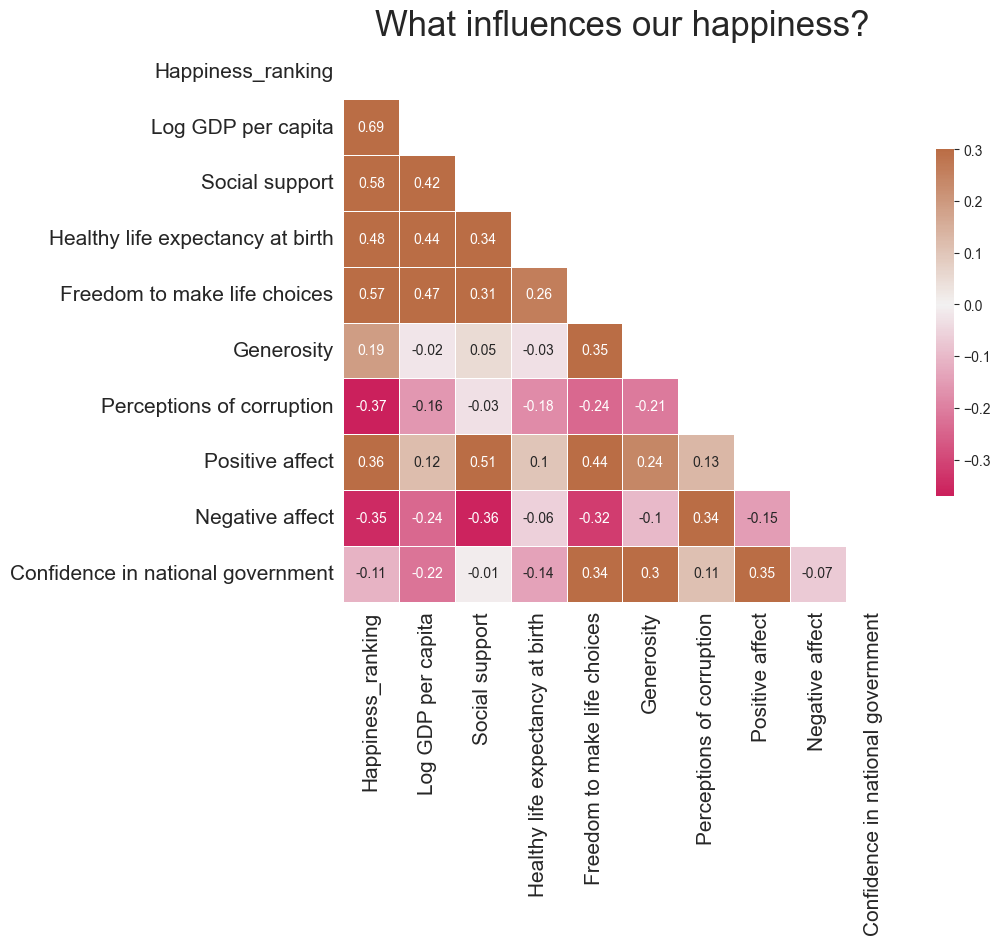

In [59]:
# Computing the Correlation Matrix

sns.set_style('whitegrid')
sns.set_palette('Set2')

corr = data_model.corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('What influences our happiness?', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


### Pearson Correlation

In [56]:
# Calculating the Pearson Correlation
from decimal import Decimal

c1 = scipy.stats.pearsonr(world_happiness['Happiness_ranking'],world_happiness['Log GDP per capita'])
c2 = scipy.stats.pearsonr(world_happiness['Happiness_ranking'], world_happiness['Social support'])
c3 = scipy.stats.pearsonr(world_happiness['Happiness_ranking'], world_happiness['Healthy life expectancy at birth'])
c4 = scipy.stats.pearsonr(world_happiness['Happiness_ranking'], world_happiness['Freedom to make life choices'])
c5 = scipy.stats.pearsonr(world_happiness['Happiness_ranking'], world_happiness['Generosity'])
c6 = scipy.stats.pearsonr(world_happiness['Happiness_ranking'], world_happiness['Positive affect'])
c7 = scipy.stats.pearsonr(world_happiness['Happiness_ranking'], world_happiness['Negative affect'])
c8 = scipy.stats.pearsonr(world_happiness['Happiness_ranking'], world_happiness['Confidence in national government'])


print('Happiness Score + GDP: pearson =', round(c1[0],2), '   pvalue = ', round(c1[1],4))
print('Happiness Score + Social Support: pearson =', round(c2[0],2), '   pvalue = ', round(c2[1],4))
print('Happiness Score + Health: pearson =', round(c3[0],2), '   pvalue = ', round(c3[1],4))
print('Happiness Score + Freedom: pearson =', round(c4[0],2), '   pvalue = ', round(c4[1],4))
print('Happiness Score + Generosity: pearson =', round(c5[0],2), '   pvalue = ', round(c5[1],4))
print('Happiness Score + Positive Affect: pearson =', round(c6[0],2), '   pvalue = ', round(c6[1],4))
print('Happiness Score + Negative Affect =', round(c6[0],2), '   pvalue = ', round(c6[1],4))
print('Happiness Score + Trust: pearson =', round(c6[0],2), '   pvalue = ', round(c6[1],4))

Happiness Score + GDP: pearson = 0.66    pvalue =  0.0
Happiness Score + Social Support: pearson = 0.6    pvalue =  0.0
Happiness Score + Health: pearson = 0.4    pvalue =  0.0
Happiness Score + Freedom: pearson = 0.44    pvalue =  0.0
Happiness Score + Generosity: pearson = 0.18    pvalue =  0.0
Happiness Score + Positive Affect: pearson = 0.43    pvalue =  0.0
Happiness Score + Negative Affect = 0.43    pvalue =  0.0
Happiness Score + Trust: pearson = 0.43    pvalue =  0.0
